# Model 5

## Data preprocessing

In [1]:
# Setup
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import normalize
from tqdm.auto import trange, tqdm
from seaborn import set_theme
import pickle

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
# device = "cpu"
print(f"DEVICE: {device}")
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

DEVICE: cuda


In [2]:
class StatesAndForces(Dataset):

    def __init__(self, states, forces):
        super().__init__()
        self.states = states
        self.forces = forces
        if len(states) == len(forces):
            self.length = len(states)
        else:
            raise ValueError("States and forces must be the same length.") 

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        force = self.states[index]
        state = self.forces[index]
        force = torch.tensor(force, dtype=torch.float32)
        state = torch.tensor(state, dtype=torch.float32)
        
        return force, state
    
class ModelA(nn.Module):

    def __init__(self, input_layer, output_layer, hidden_layers, activation_function=nn.ReLU()):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_layer, hidden_layers),
            nn.Linear(hidden_layers, hidden_layers),
            activation_function,
            nn.Linear(hidden_layers, hidden_layers),
            activation_function,
            nn.Linear(hidden_layers, output_layer)
        )

    def forward(self, x):
        return self.layers(x)
    
def preprocessing_from_matlab(data, n_data=20001):
    key = list(data.keys())[-1]
    all_data = data[key].squeeze()
    all_data_normalized = []
    all_data_norms = []

    for data in all_data:
        data_normalized, data_norms = normalize(X=data.T[:n_data],
                                                axis=0,
                                                return_norm=True)
        data_norms
        all_data_normalized.append(data_normalized)
        all_data_norms.append(data_norms)

    return all_data_normalized, all_data_norms

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        return loss

def test(dataloader, model, loss_fn):
    model.eval()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

    with torch.inference_mode():
        test_pred = model(X)
        test_loss = loss_fn(test_pred, y)

    return test_loss


In [3]:
# Loading the MATLAB files.
forces = loadmat("../../../../tau_all.mat")
states = loadmat("../../../../xs_all.mat")

In [4]:
all_forces, forces_norms = preprocessing_from_matlab(forces, n_data=5000)
all_states, states_norms = preprocessing_from_matlab(states, n_data=5000)

In [5]:
dataset = StatesAndForces(all_states, all_forces)

In [6]:
train_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE,
                             shuffle=True)

print(f"Lenght of train data: {len(train_dataloader)}")
print(f"Lenght of test data: {len(test_dataloader)}")

Lenght of train data: 800
Lenght of test data: 200


In [7]:
print("Input:")
display(pd.DataFrame(train_data[500][0]))
print("Output:")
display(pd.DataFrame(train_data[500][1]))

Input:


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.084477
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.084477
2,0.000000e+00,0.000000e+00,1.874588e-04,0.000000,0.000000,-0.000853,0.000000e+00,0.000000e+00,3.587084e-08,0.000000,0.000000,0.084473
3,0.000000e+00,0.000000e+00,3.749176e-04,-0.000341,0.008496,-0.001706,0.000000e+00,0.000000e+00,1.434834e-07,-0.000001,0.000022,0.084462
4,7.275491e-08,4.350009e-08,5.616262e-04,-0.000683,0.016990,-0.002556,2.677629e-11,1.318920e-11,3.226940e-07,-0.000004,0.000088,0.084444
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,9.209060e-03,2.105428e-03,2.078715e-07,0.000444,-0.000606,-0.000005,2.006794e-02,9.462547e-03,1.630561e-02,-0.003511,-0.000791,0.000004
4996,9.206780e-03,2.114977e-03,1.992642e-07,0.000447,-0.000605,-0.000006,2.007471e-02,9.463826e-03,1.630561e-02,-0.003508,-0.000794,0.000004
4997,9.204491e-03,2.124519e-03,1.906908e-07,0.000449,-0.000605,-0.000006,2.008149e-02,9.465111e-03,1.630561e-02,-0.003505,-0.000797,0.000003
4998,9.202193e-03,2.134052e-03,1.821513e-07,0.000451,-0.000605,-0.000006,2.008826e-02,9.466402e-03,1.630561e-02,-0.003502,-0.000800,0.000003


Output:


,0,1,2,3
0,0.014067,0.000000,0.000000,0.000000
1,0.018800,0.000000,0.000000,-0.092897
2,0.018800,-0.045472,0.422546,-0.092897
3,0.018781,-0.045514,0.422464,-0.092491
4,0.018762,-0.045168,0.374623,-0.092076
...,...,...,...,...
4995,0.014069,0.000302,0.000013,-0.000001
4996,0.014069,0.000298,0.000013,-0.000001
4997,0.014069,0.000295,0.000013,-0.000001
4998,0.014069,0.000291,0.000013,-0.000001


## Creating the Model

In [8]:
INPUT_LAYER = 12
HIDDEN_LAYERS = 25
OUTPUT_LAYER = 4
ACTIVATION_FUNCTION = nn.ReLU()

model = ModelA(input_layer=INPUT_LAYER,
               hidden_layers=HIDDEN_LAYERS,
               output_layer=OUTPUT_LAYER,
               activation_function=ACTIVATION_FUNCTION).to(device)
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# model.state_dict()

## Training the model

In [9]:
epochs = 1000
loss_overall = []
loss_overall_test = []

for epoch in trange(epochs): 
    loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Test loss: {test_loss:.5f}")
        print("~"*50)
    loss_overall.append(loss.item())
    loss_overall_test.append(test_loss.item())
    
print("Done!")

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.14062 | Test loss: 0.13707
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 200 | Train loss: 0.00401 | Test loss: 0.00387
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 400 | Train loss: 0.00343 | Test loss: 0.00352
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 600 | Train loss: 0.00277 | Test loss: 0.00270
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 800 | Train loss: 0.00215 | Test loss: 0.00205
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Done!


## Evaluating the model

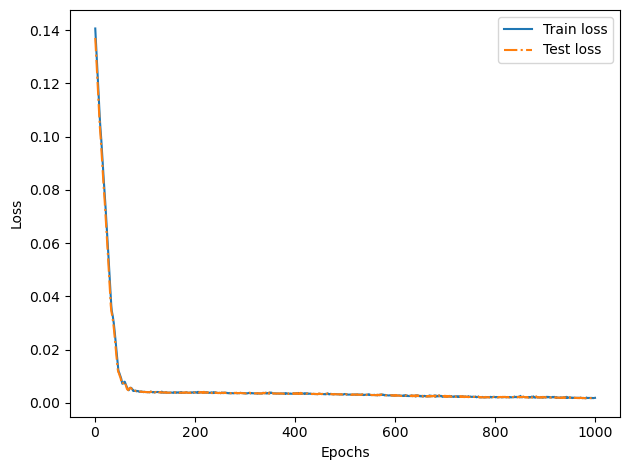

In [10]:
t = np.linspace(1, epochs, epochs)
fig, ax = plt.subplots()

ax.plot(t, loss_overall, label='Train loss')
ax.plot(t, loss_overall_test, label='Test loss', ls="-.")
ax.set_xlabel('Epochs')
ax.set_ylabel("Loss")
ax.legend()
fig.tight_layout()

In [11]:
model.eval()

with torch.inference_mode():
    my_inference = model(test_data[150][0].to(device))

with open("test_variables.pkl", "wb") as f:
    pickle.dump([test_data[150], my_inference], f)

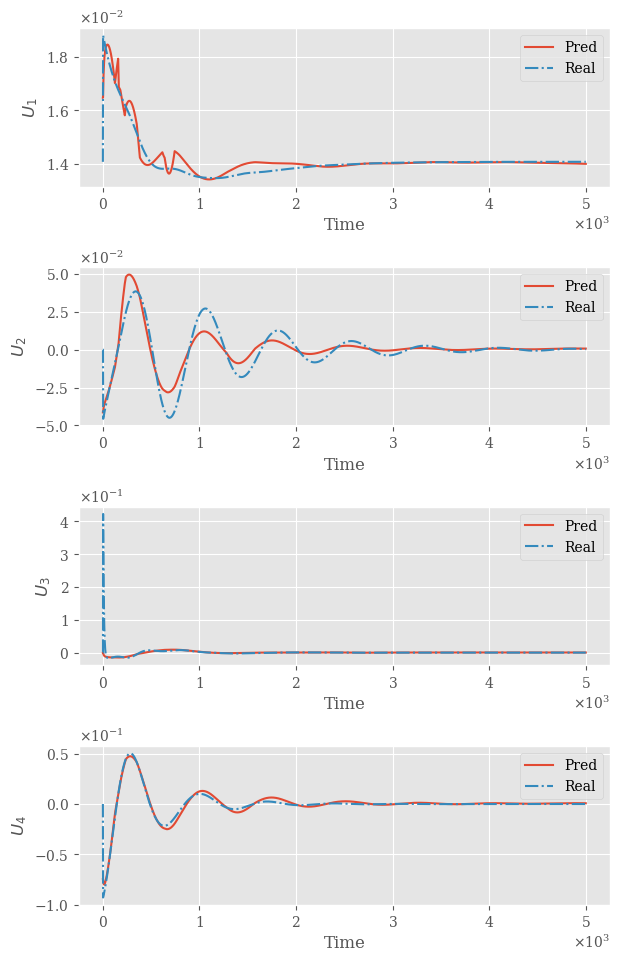

In [12]:
AXIS_SIZE = 5000
plt.style.use("ggplot")
plt.rcParams["font.family"] = "serif"
cm=1/2.54
t = np.arange(0,AXIS_SIZE,1)
fig, axs = plt.subplots(4,1, figsize=(16*cm,24.7*cm))

for i, ax in enumerate(axs.flatten()):
    ax.plot(t, my_inference[:AXIS_SIZE,i].to("cpu"), label="Pred")
    ax.plot(t, test_data[150][1][:AXIS_SIZE,i], label="Real", ls="-.")
    ax.set_ylabel(f"$U_{i+1}$")
    ax.set_xlabel("Time")
    ax.legend(loc="best")
    ax.ticklabel_format(style="sci",
                        scilimits=(0,0),
                        useMathText=True)

fig.tight_layout()
fig.savefig("../../../report/figures/4results/uav/forces_normalized.pgf", backend="pgf")

In [13]:
torch.save(model.state_dict(), "model.pt")